<a id='top'></a>

# Python walk-through for Titanic data analysis

## *This is a work in progress. Comments and critical feedback are always welcome.*

**Note:** This is not a streamlined analysis, but it contains certain redundancies with the purpose of featuring and exploring different visualisation and modelling tools that can be useful in approaching a binary classification problem. I'm happy to see that my notes are useful for others who are starting out in data analysis and machine learning, and I hope that you will be able to get some inspiration from this kernel.

As the kernel continues to grow it is branching out in more detail into the different data analysis steps. This adds more depth to the overall content, but it also makes the whole notebook rather extensive. If you're very new to this subject then I recommend to go through each section on it's own (e.g. by playing with a forked copy) rather than reading the whole thing in one go. Of course, for newbies I also recommend the excellent kernels featured in the [Titanic Tutorials](https://www.kaggle.com/c/titanic#tutorials). 

For those of you who prefer *R* over *Python* or want to try out both: I'm currently building a new [R kernel for Titanic](https://www.kaggle.com/headsortails/tidy-titarnic/) along the same philosophy as this one here. Feel free to check it out and let me know your feedback :-)  

## Outline:

*(Note: the hyper links "kind of" work, in that they take you to the corresponding section but create a separate HTML page every time you click one of them. Plus, scrolling only works with arrow keys [at least for me on Firefox]. Feel free to try them out and let me know whether you find them useful.)*

1. [Load Data and Modules](#load) (complete)
1. [Initial Exploration](#explore) (complete)
1. [Relations between features](#relations) (complete)
1. [Missing values](#missing) (complete)
1. [Derived (engineered) features](#derived) (largely complete)
1. [Preparing for modelling](#encode) (complete)
1. [Modelling](#model) (medium completeness; to be extended)
1. [Preparing our prediction for submission](#submit) (complete)

<a id='load'></a>

# **1. Load Data and Modules**

**Load Python modules:** The list of modules grows step by step by adding new functionality that is useful for this project. A module could be defined further down once it is needed, but I prefer to have them all in one place to keep an overview.

In [0]:
#%matplotlib inline

# for seaborn issue:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats
import sklearn as sk
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import svm
import xgboost as xgb
import lightgbm as lgb
from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

sns.set(style='white', context='notebook', palette='deep')

**Load input data.** And combine the available features of train and test data sets. *test* of course doesn't have the column that indicates survival.

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# train = pd.read_csv("../input/train.csv")
# test = pd.read_csv("../input/test.csv")
# combine = pd.concat([train.drop('Survived',1),test])
path = "/content/gdrive/My Drive/input"
train = pd.read_csv(path+"/train.csv")
test = pd.read_csv(path+"/test.csv") 
combine = pd.concat([train.drop('Survived',1),test])

<a id='explore'></a>

# 2. Initial Exploration

**Look at your data in as many different ways as possible.** Some properties and connections will be immediately obvious. Others will require you to examine the data, or parts of it, in more specific ways. Metaphorically speaking: this is the part where the detective finds the clues.

First a broad overview. What are the types of data and their typical shape and content?

In [5]:
train.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


Together with the PassengerId which is just a running index and the indication whether this passenger survived (1) or not (0) we have the following information for each person:

- *Pclass* is the Ticket-class: first (1), second (2), and third (3) class tickets were used. This is an ordinal integer feature. 

- *Name* is the name of the passenger. The names also contain titles and some persons might share the same surname; indicating family relations. We know that some titles can indicate a certain age group. For instance *Master* is a boy while *Mr* is a man. This feature is a character string of variable length but similar format.

- *Sex* is an indicator whether the passenger was female or male. This is a categorical text string feature. 

- *Age* is the integer age of the passenger. There are NaN values in this column.

- *SibSp* is another ordinal integer feature describing the number of siblings or spouses travelling with each passenger.

- *Parch* is another ordinal integer features that gives the number of parents or children travelling with each passenger.

- *Ticket* is a character string of variable length that gives the ticket number.

- *Fare* is a float feature showing how much each passenger paid for their rather memorable journey.

- *Cabin* gives the cabin number of each passenger. There are NaN in this column. This is another string feature.

- *Embarked* shows the port of embarkation as a categorical character value.

In summary we have 1 floating point feature (*Fare*), 1 integer variable (*Age*), 3 ordinal integer features (*Plcass, SibSp, Parch*), 2 categorical text features (*Sex, Embarked*), and 3 text string features (*Ticket, Cabin, Name*).

In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The minimum/maxim values for pclass, age, sibsp, parch show us the range of these features. Also we see that there's quite a range in fares.

### *Missing values*

In [7]:
print(train.isnull().sum())
print(test.info())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


Knowing about missing values is important because they indicate how much we don't know about our data.  Making inferences based on just a few cases is often unwise. In addition, many modelling procedures break down when missing values are involved and the corresponding rows will either have to be removed completely or the values need to be estimated somehow.

**We learn:**

- In the **training data** a large majority of *Cabin* numbers are missing, together with 177 *Age* values and 2 *Embarked* values. 

- Also, in the **test** data there is one *Fare* missing (cheeky selection), almost 100 *Age* values are unknown, and only 91 *Cabin* numbers were preserved. Best to keep that in mind.

In [8]:
surv = train[train['Survived']==1]
nosurv = train[train['Survived']==0]
surv_col = "blue"
nosurv_col = "red"

print("Survived: %i (%.1f percent), Not Survived: %i (%.1f percent), Total: %i"\
      %(len(surv), 1.*len(surv)/len(train)*100.0,\
        len(nosurv), 1.*len(nosurv)/len(train)*100.0, len(train)))

Survived: 342 (38.4 percent), Not Survived: 549 (61.6 percent), Total: 891


In our training data set about 60% of the passengers didn't survive. By flat out predicting that everyone in the testing data set died we would get a 60% accuracy. Let's try to do better than that.

Here we also define a consistent colour scheme for the distinguishing between survived / not survived. This scheme will (soon) be used throughout this kernel.

OK, let's go through the features one by one to see what we find. Here we will see how the distributions of survivors and non-survivors compare. Personally, I like histograms for a first look at comparing two or more populations in case of scaled features. For categorical features we will use barplots plus standard deviation bars, to better judge the significance.

Median age survivors: 28.0, Median age non-survivers: 28.0


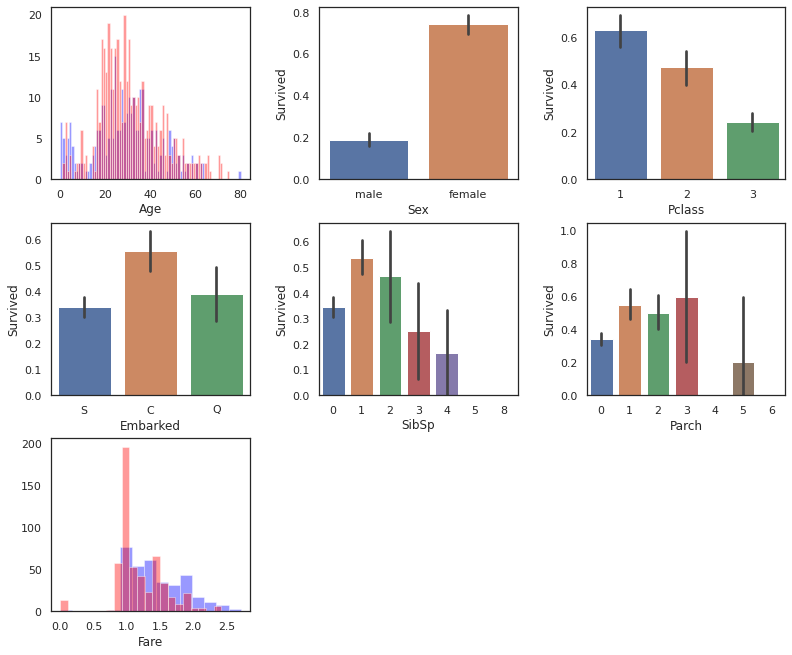

In [9]:
warnings.filterwarnings(action="ignore")
plt.figure(figsize=[12,10])
plt.subplot(331)
sns.distplot(surv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=surv_col)
sns.distplot(nosurv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=nosurv_col,
            axlabel='Age')
plt.subplot(332)
sns.barplot('Sex', 'Survived', data=train)
plt.subplot(333)
sns.barplot('Pclass', 'Survived', data=train)
plt.subplot(334)
sns.barplot('Embarked', 'Survived', data=train)
plt.subplot(335)
sns.barplot('SibSp', 'Survived', data=train)
plt.subplot(336)
sns.barplot('Parch', 'Survived', data=train)
plt.subplot(337)
sns.distplot(np.log10(surv['Fare'].dropna().values+1), kde=False, color=surv_col)
sns.distplot(np.log10(nosurv['Fare'].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

print("Median age survivors: %.1f, Median age non-survivers: %.1f"\
      %(np.median(surv['Age'].dropna()), np.median(nosurv['Age'].dropna())))

Above we are creating a kind of summary dashboard, where we collect relevant visualisations to study the distributions of the individual features. We use the matplotlib *subplot* tool to line up the individual plots in a grid. We use overlapping histograms for ordinal features and barplots for categorical features. The barplots show the fraction of people (per group) who survived. There's a lot going on in this figure, so take your time to look at all the details.

**We learn** the following things from studying the individual features:

- *Age:* The medians are identical. However, it's noticeable that fewer young adults have survived (ages 18 - 30-ish) whereas **children younger than 10-ish had a better survival rate.** Also, there are no obvious outliers that would indicate problematic input data. The highest ages are well consistent with the overall distribution. There is a notable shortage of teenagers compared to the crowd of younger kids. But this could have natural reasons.

- *Pclass:* There's a clear trend that **being a 1st class passenger gives you better chances of survival**. Life just isn't fair.

- *SibSp & Parch:* **Having 1-3 siblings/spouses/parents/children on board (SibSp = 1-2, Parch = 1-3) suggests proportionally better survival numbers than being alone (SibSp + Parch = 0) or having a large family travelling with you.**

- *Embarked:* Well, that does look more interesting than expected.  **Embarking at "C" resulted in a higher survival rate than embarking at "S"**. There might be a correlation with other variables, here though.

- *Fare:* This is case where a linear scaling isn't of much help because there is a smaller number of more extreme numbers. A natural choice in this case is to transform the values logarithmically. For this to work we need to adjust for the zero-fare entries.  The plot tells us that the **survival chances were much lower for the cheaper cabins**. Naively, one would assume that those cheap cabins were mostly located deeper inside the ship, i.e. further away from the life boats.

A little follow up: For *SibSp* we see in the plot that most of the differences are not very significant (overlapping error bars). Another way of checking the actual numbers are through *cross tables*:

In [10]:
tab = pd.crosstab(train['SibSp'], train['Survived'])
print(tab)
#dummy = tab.div(tab.sum(1).astype(float), axis=0).plot(kind="bar", 
#                         stacked=True, color=[nosurv_col,surv_col])
#dummy = plt.xlabel('SibSp')
#dummy = plt.ylabel('Percentage')

Survived    0    1
SibSp             
0         398  210
1          97  112
2          15   13
3          12    4
4          15    3
5           5    0
8           7    0


 Passengers with more than 3 children+parents on board had low survival chances. However the corresponding number are not very large. For SibSp we have 15 vs 3, 5 vs 0, and 7 vs 0.

Random outcomes with 2 possibilities (like *heads or tails* when flipping a coin) follow the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). We can use a *binomial test* to estimate the probability that 5 non-survivors out of a total 5 passengers with SibSp = 5 happened due to chance assuming the overall 38% survival chance for the entire sample.

In [11]:
stats.binom_test(x=5,n=5,p=0.62)

0.16417601599999998

Anything above 0.05 is usually not significant and therefore solely based on these numbers we cannot say whether the SibSp = 5 sample behaves different than the rest.

For larger numbers of Parch we have 4 vs 0, 4 vs 1, and 1 vs 0. Just by themselves, the last two are definitely not impressive. Combining them into parch >= 4 gives us 9 vs 1 which is much better.

**We learn:** parch >= 4 and sibsp >= 3 is bad. So is parch + sibsp = 0 (i.e. both 0). Parch in 1-3 and Sibsp in 1-2 is good.

### *Cabin numbers*

This is a tricky feature because there are so many missing values and the strings don't all have the same number or formatting.

In [12]:
print("We know %i of %i Cabin numbers in the training data set and"
      %(len(train['Cabin'].dropna()), len(train)))
print("we know %i of %i Cabin numbers in the testing data set."
      %(len(test['Cabin'].dropna()), len(test)))
train.loc[:,['Survived','Cabin']].dropna().head(8)

We know 204 of 891 Cabin numbers in the training data set and
we know 91 of 418 Cabin numbers in the testing data set.


,Survived,Cabin
1,1,C85
3,1,C123
6,0,E46
10,1,G6
11,1,C103
21,1,D56
23,1,A6
27,0,C23 C25 C27


**We can try out:**

- I suppose one could take the starting letters, which might indicate specific decks on the ship, and use them as an additional classifier. But for less than 25% of cabins known this might not be very useful. We'll see.

- Also, given that so few cabin numbers are know it doesn't seem that there are good records of them. Therefore, one should assume that it's more likely to know someone's cabin number if they survived. Let's see about that in the derived features.

*TODO: Why do some people have multiple cabin numbers? What does that mean?*

## *Ticket numbers*

That seems to be a hopeless variable at first because it just looks like random strings. But in these days, when you were travelling as a group/family did everyone really get their own ticket? Let's find out how many unique ticket numbers there are:

In [0]:
print("There are %i unique ticket numbers among the %i tickets." \
      %(train['Ticket'].nunique(),train['Ticket'].count()))

Interesting. Sharing a ticket number is not uncommon. Let's follow that up a bit.

In [0]:
grouped = train.groupby('Ticket')
k = 0
for name, group in grouped:
    if (len(grouped.get_group(name)) > 1):
        print(group.loc[:,['Survived','Name', 'Fare']])
        k += 1
    if (k>10):
        break

**We can try out:**

Working hypothesis: if your group (mostly family) survived then you survived as well, unless you were a man (and presumably helped your wife/daughter/lady friend). We could go through the trouble here to identify families by last name. However

 1. Common last names might not be unique in the passenger list
 2. As we see above a ticket is not always shared by people with a common name.

Therefore, a shared ticket might actually be a stronger predictor. Of course this assumption should be tested by doing the last-name thing too. In addition, we see that the *Fare* was identical for all the passengers in each ticket group. This is something we will explore in more detail below.

<a id='relations'></a>

[Go to the top of the page](#top)

# 3. Relations between features

After inspecting the available features individually you might have realised that some of them are likely to be connected. Does the age-dependent survival change with sex? How are pclass and fare related? Are they strongly enough connected so that one of them is superfluous? Let's find out.

Now we are connecting individual clues to get a glimpse of the bigger picture.

We start with an **overview plot of the feature relations:** Here we show a *correlation matrix* for each numerical variable with all the other numerical variables. We excluded *PassengerID*, which is merely a row index. In the plot, stronger correlations have brighter colours in either red (positive correlation) or blue (negative correlation). The closer to white a colour is the weaker the correlation. 

In [0]:
plt.figure(figsize=(14,12))
foo = sns.heatmap(train.drop('PassengerId',axis=1).corr(), vmax=0.6, square=True, annot=True)

*Positive vs negative correlation* needs to be understood in terms of whether an increase in one feature leads to an increase (positive) or decrease (negative) in the correlated feature. Perfect correlation would have a correlation index of 1; perfect anti-correlation (= negative correlation) would have -1 (obviously each feature is perfectly correlated with itself; leading to the deep red diagonal). The upper right vs lower left triangle that make up this plot contain the same information, since the corresponding cells show the correlation coefficients of the same features. 

The matrix gives us an overview as to which features are particularly interesting for our analysis. Both strongly positive or negative correlations with the *Survived* feature are valuable. Strong correlations between two other features would suggest that only one of them is necessary for our model (and including the other would in fact induce noise and potentially lead to over-fitting).

**We learn:**

- *Pclass* is somewhat correlated with *Fare* (1st class tickets would be more expensive than 3rd class ones)
- *SibSp* and *Parch* are weakly correlated (large families would have high values for both; solo travellers would have zero for both)
- *Pclass* already correlates with *Survived* in a noticeable way

In addition, we plot a **Pairplot** of the numerical features. This kind of plot is a more detailed visualisation of relationships between variables. It shows scatter plots for the different feature combinations plus a distribution of each feature on the diagonal. Again, the upper right and lower left triangle contain the same information. This kind of plot is vastly more useful for a set of continuous variables, instead of the categorical or integer values we have here. Nonetheless, it is a valuable exploratory tool that has a place in everyone's toolbox.

This plot is inspired by, and realised much more aesthetically in, the [comprehensive Ensemble Stacking Kernel by Anisotropic](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)  

In [0]:
cols = ['Survived','Pclass','Age','SibSp','Parch','Fare']
g = sns.pairplot(data=train.dropna(), vars=cols, size=1.5,
                 hue='Survived', palette=[nosurv_col,surv_col])
g.set(xticklabels=[])

Now we continue to examine these initial indications in more detail. Earlier, we had a look at the *Survived* statistics of the individual features in the overview figure. Here, we want to look at correlations between the predictor features and how they could affect the target *Survived* behaviour.

Usually it's most interesting to start with the strong signals in the correlation plot and to examine them more in detail.

In [0]:
msurv = train[(train['Survived']==1) & (train['Sex']=="male")]
fsurv = train[(train['Survived']==1) & (train['Sex']=="female")]
mnosurv = train[(train['Survived']==0) & (train['Sex']=="male")]
fnosurv = train[(train['Survived']==0) & (train['Sex']=="female")]

plt.figure(figsize=[13,5])
plt.subplot(121)
sns.distplot(fsurv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=surv_col)
sns.distplot(fnosurv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=nosurv_col,
            axlabel='Female Age')
plt.subplot(122)
sns.distplot(msurv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=surv_col)
sns.distplot(mnosurv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=nosurv_col,
            axlabel='Male Age')

**We learn:**

- For females the survival chances appear to be higher between 18 and 40, whereas for men in that age range the odds are flipped. This difference between 18-40 yr olds might be a better feature than *Sex* and *Age* by themselves.

- Boys have proportional better survival chances than men, whereas girls have similar chances as women have. Rather small numbers, though. 

We study the correlation of *Age* with *Pclass* using a *violin plot*, which is also split between survived (right half) and not survived (left half). Check out the other visualisations in your forked copy.

In [0]:
#foo = combine['Age'].hist(by=combine['Pclass'], bins=np.arange(0,81,1),
#                          layout=[3,1], sharex=True, figsize=[8,12])

#foo = sns.boxplot(x="Pclass", y="Age", hue="Survived", data=train)

#sns.violinplot(x="Pclass", y="Age", data=combine, inner=None)
#sns.swarmplot(x="Pclass", y="Age", data=combine, color="w", alpha=.5)

sns.violinplot(x="Pclass", y="Age", hue="Survived", data=train, split=True)
plt.hlines([0,10], xmin=-1, xmax=3, linestyles="dotted")

*Violin plots* are a modified version of boxplots, where the shape is a "kernel density estimate" of the underlying distribution. These estimates are smoothed and therefore extend beyond the actual values (look closely at the dotted zero level). I have also indicated *Age == 10*, which we will use to define children (vs teenagers) in the engineering part below.

**We learn:**

- Age decreases progressively as Pclass decreases from 1st to 3rd
- Most older passengers are 1st class, but very few children are. This conflates the impact of *Age* and *Pclass* on the survival chances.
- In 1st class, younger adults had better survival chances than older ones.
- Most children in 2nd class survived, and the majority in 3rd class did too.

For a view into *Pclass* vs *Sex* let's use a *mosaic plot* for a 2-dimensional overview.

In [0]:
dummy = mosaic(train,["Survived","Sex","Pclass"])

Also, we will start to use *factorplots*, i.e. groups of *pointplots*, from the *seaborn* plotting package to visualise the categorical relations:

In [0]:
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", col="Embarked",
                   data=train, aspect=0.9, size=3.5, ci=95.0)

# for some reason in this plot the colours for m/f are flipped:
#grid = sns.FacetGrid(train, col='Embarked', size=2.2, aspect=1.6)
#grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', ci=95.0, palette='deep')
#grid.add_legend()

**We learn:**

- Both the factorplot and the mosaicplot indicate that almost all females that died were 3rd class passengers.
- For males being in 1st class gives a survival boost, otherwise the proportions look roughly similar.
- Except for 3rd class, the survival for *Embarked == Q* is close to 100% split between male and female.

Let's follow up the numbers for *Pclass vs Embarked* with a *pandas crosstab plot*:

In [0]:
tab = pd.crosstab(combine['Embarked'], combine['Pclass'])
print(tab)
dummy = tab.div(tab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
dummy = plt.xlabel('Port embarked')
dummy = plt.ylabel('Percentage')

**We learn:**

- a high percentage of those embarked at "C" were 1st class passengers.
- almost everyone who embarked at "Q" went to 3rd class (this means that the clear separation in the factorplot for "Q" isn't very meaningful, unfortunately).

The 2nd point is somewhat curious, since we recall from above that the survival chances for "Q" were actually slightly better than for "S". Not significantly so, of course, but certainly not worse even though "S" had a higher percentage of 1st and 2nd class passengers.

It seems that embarking at "Q" improved your chances for survival if you were a 3rd class passenger. Let's investigate that a bit more:

In [0]:
sns.barplot(x="Embarked", y="Survived", hue="Pclass", data=train)

Ok, now from here it looks more like "S" is the interesting port since survival is less probably for that one if you are a 3rd class passenger. Otherwise  there is no significant difference within each class.

There seems to be some impact here that isn't captured by the passenger class. What about the other strong feature, Sex?

In [0]:
tab = pd.crosstab(combine['Embarked'], combine['Sex'])
print(tab)
dummy = tab.div(tab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
dummy = plt.xlabel('Port embarked')
dummy = plt.ylabel('Percentage')

Now this is somewhat expected since it explains the difference between "S" and the other ports. Therefore, it seems that between more 1st class passengers embarking at "C" and more men at "S" there doesn't seem to be much actual influence in the port of embarkation.

However, the last plot should also indicate that ...

In [0]:
tab = pd.crosstab(combine['Pclass'], combine['Sex'])
print(tab)
dummy = tab.div(tab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
dummy = plt.xlabel('Pclass')
dummy = plt.ylabel('Percentage')

... there were more males among the 3rd class passengers. Possibly travelling alone?

In [0]:
sib = pd.crosstab(train['SibSp'], train['Sex'])
print(sib)
dummy = sib.div(sib.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
dummy = plt.xlabel('Siblings')
dummy = plt.ylabel('Percentage')

parch = pd.crosstab(train['Parch'], train['Sex'])
print(parch)
dummy = parch.div(parch.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
dummy = plt.xlabel('Parent/Children')
dummy = plt.ylabel('Percentage')

Sort of, yes. This goes some way to explain features like better survival for SibSp = 1-3. But I think that it doesn't cover all the signal in the Parch feature.

**We learn:**

- Different percentages of passenger classes and sexes have embarked from different ports, which is reflected in the lower survival rates for "S" (more men, fewer 1st class) compared to "C" (more women and 1st class).

- It's hard to say at this stage whether there is any real impact left for the *Embarked* feature once we correct for these connections. We will come back to this in the modelling stage when we will study feature importances and significances (soon).

Finally, let's check what's going on between *Age* and *Embarked*:

In [0]:
sns.violinplot(x="Embarked", y="Age", hue="Survived", data=train, split=True)
plt.hlines([0,10], xmin=-1, xmax=3, linestyles="dotted")

The curious distribution for the "Q" survivors somewhat follows the overall trend for 3rd class passengers (which make up the vast majority of "Q") but is notably narrower. Not many of the children there survived, but then there were not many children to begin with. Let's come back to this point in discussing the derived features.

**We learn:**
There don't seem to be strong differences in *Age* among the *Embarked* categories that would point at an imbalance that goes beyond the influence of *Pclass* and *Sex*. 

Let's study the relation between *Fare* and *Pclass* in more detail:

In [0]:
plt.figure(figsize=[12,10])
plt.subplot(311)
ax1 = sns.distplot(np.log10(surv['Fare'][surv['Pclass']==1].dropna().values+1), kde=False, color=surv_col)
ax1 = sns.distplot(np.log10(nosurv['Fare'][nosurv['Pclass']==1].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
ax1.set_xlim(0,np.max(np.log10(train['Fare'].dropna().values)))
plt.subplot(312)
ax2 = sns.distplot(np.log10(surv['Fare'][surv['Pclass']==2].dropna().values+1), kde=False, color=surv_col)
ax2 = sns.distplot(np.log10(nosurv['Fare'][nosurv['Pclass']==2].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
ax2.set_xlim(0,np.max(np.log10(train['Fare'].dropna().values)))
plt.subplot(313)
ax3 = sns.distplot(np.log10(surv['Fare'][surv['Pclass']==3].dropna().values+1), kde=False, color=surv_col)
ax3 = sns.distplot(np.log10(nosurv['Fare'][nosurv['Pclass']==3].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
ax3.set_xlim(0,np.max(np.log10(train['Fare'].dropna().values)))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

**We learn:**

- There is a broad distribution between the 1st class passenger fares (rich -> super rich)
- There's an interesting bimodality in the 2nd class cabins and a long tail in the 3rd class ones. (*TODO: check cumulative fare question*)
- For each class there is strong evidence that the cheaper cabins were worse for survival. A similar effect can be seen in a *boxplot*:

In [0]:
ax = sns.boxplot(x="Pclass", y="Fare", hue="Survived", data=train);
ax.set_yscale('log')

<a id='missing'></a>

[Go to the top of the page](#top)

# 4. Filling in missing values

After studying the relations between the different features let's fill in a few missing values based on what we learned.

In my opinion, the only training feature for which it makes sense to fill in the NAs is *Embarked*. Too many *Cabin* numbers are missing. And for *Age* we will choose a different approach below. We fill in the 1 missing *Fare* value in the test data frame accordingly.

Let's find the two passengers and assign the most likely port based on what we found so far:

In [0]:
print(train[train['Embarked'].isnull()])

These are two women that travelled together in 1st class, were 38 and 62 years old, and had no family on board.

In [0]:
combine.where((combine['Embarked'] !='Q') & (combine['Pclass'] < 1.5) & \
    (combine['Sex'] == "female")).groupby(['Embarked','Pclass','Sex','Parch','SibSp']).size()

Admittedly, these are quite a few grouping levels, but 30 ("C") vs 20 ("S") are numbers that are still large enough to be useful in this context. In addition, already a grouping without the *Parch* and *SibSp* features suggests similar numbers for women in 1st class embarking from "C" (71) vs "S" (69) (in contrast to the larger overall number of all 1st class passengers leaving from "S").

Another recent kernel ([definitely worth checking out](https://www.kaggle.com/varimp/a-mostly-tidyverse-tour-of-the-titanic)) makes a convincing case for predicting *Embarked == "S"* for these two passengers (see also the comments). However, in my opinion we have better reasons to impute "C" instead. I recommend that you weigh the arguments and make your own decision.

*(How much does it actually matter? Well, in the big picture these are only 2 passengers and their impact on our model accuracy won't be large. However, since the main point of this challenge is to practice data analysis it is certainly worth to take your time to examine the question in a bit more detail.)*

In [0]:
train['Embarked'].iloc[61] = "C"
train['Embarked'].iloc[829] = "C"

In [0]:
print(test[test['Fare'].isnull()])

In [0]:
print(test[test['Fare'].isnull()])

A 60-yr old 3rd class passenger without family on board. We will base our *Fare* prediction on the median of the 3rd-class fares:

In [0]:
test['Fare'].iloc[152] = combine['Fare'][combine['Pclass'] == 3].dropna().median()
print(test['Fare'].iloc[152])

<a id='derived'></a>

[Go to the top of the page](#top)

# 5. Derived (engineered) features

The next idea is to define new features based on the existing ones that allow for a split into survived/not-survived with higher confidence than the existing features. An example would be "rich woman" vs "poor man", but this particular distinction should be handled well by most classifiers. We're looking for something a bit more subtle here. This is the part where the detective puts individual clues together to see whether their sum is more than its parts.

This part of the analysis is called *Feature Engineering*. I prefer the approach to list all the new features that we define together in one place, to keep an overview. Every time we can think of a new feature, we come back here to define it and then study it further down. We compute the new features in the combined data set, to make sure that all feature realisations are complete, and then split the combine data again into train and test.

The clever way of computing the *Shared\_ticket* values (using *group\_by* and *np.where*) was contributed by [GeorgeChou](https://www.kaggle.com/georgechou) in the comments. Many thanks! 

In [0]:
combine = pd.concat([train.drop('Survived',1),test])
survived = train['Survived']

combine['Child'] = combine['Age']<=10
combine['Cabin_known'] = combine['Cabin'].isnull() == False
combine['Age_known'] = combine['Age'].isnull() == False
combine['Family'] = combine['SibSp'] + combine['Parch']
combine['Alone']  = (combine['SibSp'] + combine['Parch']) == 0
combine['Large_Family'] = (combine['SibSp']>2) | (combine['Parch']>3)
combine['Deck'] = combine['Cabin'].str[0]
combine['Deck'] = combine['Deck'].fillna(value='U')
combine['Ttype'] = combine['Ticket'].str[0]
combine['Title'] = combine['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
combine['Fare_cat'] = pd.DataFrame(np.floor(np.log10(combine['Fare'] + 1))).astype('int')
combine['Bad_ticket'] = combine['Ttype'].isin(['3','4','5','6','7','8','A','L','W'])
combine['Young'] = (combine['Age']<=30) | (combine['Title'].isin(['Master','Miss','Mlle']))
combine['Shared_ticket'] = np.where(combine.groupby('Ticket')['Name'].transform('count') > 1, 1, 0)
combine['Ticket_group'] = combine.groupby('Ticket')['Name'].transform('count')
combine['Fare_eff'] = combine['Fare']/combine['Ticket_group']
combine['Fare_eff_cat'] = np.where(combine['Fare_eff']>16.0, 2, 1)
combine['Fare_eff_cat'] = np.where(combine['Fare_eff']<8.5,0,combine['Fare_eff_cat'])
test = combine.iloc[len(train):]
train = combine.iloc[:len(train)]
train['Survived'] = survived

surv = train[train['Survived']==1]
nosurv = train[train['Survived']==0]

Now let's study the new features and see how they relate to the survival chances:

### *Child*

In [0]:
g = sns.factorplot(x="Sex", y="Survived", hue="Child", col="Pclass",
                   data=train, aspect=0.9, size=3.5, ci=95.0)
tab = pd.crosstab(train['Child'], train['Pclass'])
print(tab)
tab = pd.crosstab(train['Child'], train['Sex'])
print(tab)

The *Pclass == 1* plot looks interesting at first, but there are only 3 children in this group which makes the apparent pattern just random noise. The other two passenger classes are more interesting, especially for the male children. Note, that since we are selecting by *Age*, which has many missing values, a number of children will be in the *Child == False* group. Nonetheless, this seems useful.

**We learn:** Male children appear to have a survival advantage in 2nd and 3rd class. We should include the *Child* feature in our model testing.

### *Cabin\_known*

In [0]:
cab = pd.crosstab(train['Cabin_known'], train['Survived'])
print(cab)
dummy = cab.div(cab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
dummy = plt.xlabel('Cabin known')
dummy = plt.ylabel('Percentage')

As suspected, it is more likely to know the cabin of a passenger who survived. This could be useful.

In [0]:
g = sns.factorplot(x="Sex", y="Survived", hue="Cabin_known", col="Pclass",
                   data=train, aspect=0.9, size=3.5, ci=95.0)

However, we see again that a large part of this effect disappears once we control for *Sex* and *Pclass*. 

**We learn:** There remains a potential trend for males and for 3rd class passengers but the uncertainties are large. This feature should be tested in the modelling stage.

### *Deck*

In [0]:
tab = pd.crosstab(train['Deck'], train['Survived'])
print(tab)
dummy = tab.div(tab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
dummy = plt.xlabel('Deck')
dummy = plt.ylabel('Percentage')

Ok, so what can we tell from the Deck (derived from the Cabin number)? First of all the overall survival statistics is much better than for the full sample, which is what we found above. Beyond that, the best decks for survival were B, D, and E with about 66% chance. C and F are around 60%. A and G at 50%. The only passenger on deck T died, but that's hardly robust statistics.

The largest number of cases we have is for B vs C. Let's see whether that's significant:

In [0]:
stats.binom_test(x=12,n=12+35,p=24/(24.+35.))

Just about formally significant (i.e. < 5%). It might be worth our while to include this feature in at least the initial stages of modelling to see how it performs.

In [0]:
g = sns.factorplot(x="Deck", y="Survived", hue="Sex", col="Pclass",
                   data=train, aspect=0.9, size=3.5, ci=95.0)

In addition, there is some variation between the 1st class male passengers, but it doesn't look overly significant.

### *Ttype and Bad\_ticket*

Let's have a look at the ticket numbers and see whether we can extract some additional deck information from them. Above, we created a new feature called *Ttype* which defines the type of a ticket through the first digit of the ticket number.

In [0]:
print(train['Ttype'].unique())
print(test['Ttype'].unique())

In [0]:
tab = pd.crosstab(train['Ttype'], train['Survived'])
print(tab)
sns.barplot(x="Ttype", y="Survived", data=train, ci=95.0, color="blue")

Based on this plot we define a new feature called *Bad\_ticket* under which we collect all the ticket numbers that start with digits which suggest less than 25% survival (e.g. *4*, *5*, or *A*). We are aware that some of the survival fractions we see above are based on small number statistics (e.g. 2 vs 0 for *8*). It is well possible that some of our "bad tickets" are merely statistical fluctuations from the base survival rate of 38%.  The barplot shows mean survival fractions and the associated 95% confidence limits, which are large for the sparse samples.

However, the significant difference between e.g. *1* and *3* (based on large enough numbers) suggests that this new feature could still contain some useful information. I think that without external information, which we are avoiding in this notebook, we can't do much better in trying to tie the ticket number to the survival statistics.

Of course, it's not the tickets themselves that are "bad" for survival, but the possibility that the ticket numbers might encode certain areas of the ship that would have led to higher or lower survival chances.

In [0]:
tab = pd.crosstab(train['Bad_ticket'], train['Survived'])
print(tab)
g = sns.factorplot(x="Bad_ticket", y="Survived", hue="Sex", col="Pclass",
                   data=train, aspect=0.9, size=3.5, ci=95.0)

The factorplot suggests that bad tickets are worse for male passengers, and 3rd class passengers. The individual significances are not overwhelming, but the trend itself might be useful.

In [0]:
tab = pd.crosstab(train['Deck'], train['Bad_ticket'])
print(tab)
dummy = tab.div(tab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
dummy = plt.xlabel('Deck')
dummy = plt.ylabel('Percentage')

The last plot doesn't inspire much confidence in a strong correlation between *Deck* and *Bad\_ticket*, but maybe it will be useful otherwise.

**We learn:** *Bad\_ticket* might be a lower order effect that could give us some additional accuracy. We should test it out in the modelling stage.

### *Age\_known*

Similar to the known Cabin numbers, what about the *passengers for which we know the age*?

In [0]:
tab = pd.crosstab(train['Age_known'], train['Survived'])
print(tab)
dummy = tab.div(tab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
dummy = plt.xlabel('Age known')
dummy = plt.ylabel('Percentage')

As we would expect intuitively, it appears that we are more likely to know someones age if the survived the disaster. There's a difference of about 30% vs 40% and it should be significant:

In [0]:
stats.binom_test(x=424,n=424+290,p=125/(125.+52.))

Very much so. However, we have seen before that there might be imbalances in the dominating features *Sex* and *Plcass* that create an apparent signal. Is this another of these cases?

In [0]:
g = sns.factorplot(x="Sex", y="Age_known", hue="Embarked", col="Pclass",
                   data=train, aspect=0.9, size=3.5, ci=95.0)

It actually is. Turns out that we are more likely to know the age of higher class passengers or women, which are the strongest survival predictors we have found, so far. (Of course, the causality might as well go the other way, but that's not really the question here. What we want to find are the best predictors for survival.)

**We learn:** 
There is a strong impact of *Sex* and *Pclass* on this new feature. This might be enough to explain all the variance in the *Age\_known* variable. We should test the predictive power in our modelling.

### *Family*

In [0]:
tab = pd.crosstab(train['Family'], train['Survived'])
print(tab)
dummy = tab.div(tab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
dummy = plt.xlabel('Family members')
dummy = plt.ylabel('Percentage')

**We learn:**
Again, we find that having 1-3 family members works best for survival. This feature is a mix of *SibSp* and *Parch*, which increases the overall numbers we can work with, but might smooth out some more subtle effects.

### *Alone*

In [0]:
tab = pd.crosstab(train['Alone'], train['Survived'])
print(tab)
sns.barplot('Alone', 'Survived', data=train)

Travelling alone appears bad enough to be significant.

In [0]:
g = sns.factorplot(x="Sex", y="Alone", hue="Embarked", col="Pclass",
                   data=train, aspect=0.9, size=3.5, ci=95.0)

But more men were travelling alone than women did. Especially among the 3rd class passengers. Also this feature should be evaluated in our modelling step, to see if it's still significant in the presence of the *Sex* feature.

### *Large\_Family*

In [0]:
tab = pd.crosstab(train['Large_Family'], train['Survived'])
print(tab)
sns.barplot('Large_Family', 'Survived', data=train)

In the same way, having a large family appears to be not good for survival.

In [0]:
g = sns.factorplot(x="Sex", y="Large_Family", col="Pclass",
                   data=train, aspect=0.9, size=3.5, ci=95.0)

But most large families were travelling in 3rd class. The tentative imbalance between male and female 3rd class probably reflect the observation we made earlier that men were more likely to travel alone.

### *Shared\_ticket*

In [0]:
tab = pd.crosstab(train['Shared_ticket'], train['Survived'])
print(tab)
sns.barplot('Shared_ticket', 'Survived', data=train)

Sharing a ticket appears to be good for survival.

In [0]:
tab = pd.crosstab(train['Shared_ticket'], train['Sex'])
print(tab)
g = sns.factorplot(x="Sex", y="Shared_ticket", hue="Embarked", col="Pclass",
                   data=train, aspect=0.9, size=3.5, ci=95.0)

But again the sharing of tickets is more frequent with females and 1st class passengers. This is consistent with the other statistics that show that women were more likely to travel together with larger families.

**We learn:** Several of these derived parameters are strongly correlated with *Sex* and *Pclass*. Whether there is actual signal in them that a model can use to improve the learning accuracy needs to be investigated.

### *Title*

What can we learn from the titles in the passenger names? These could give us a direct, independent way to estimate the missing age values, so let's look at all the available titles, their frequency, and mean age. For this, we look at the *combined* data set to make sure that we don't miss any titles that might be in *train* or *test* only:

In [0]:
print(combine['Age'].groupby(combine['Title']).count())
print(combine['Age'].groupby(combine['Title']).mean())

print("There are %i unique titles in total."%(len(combine['Title'].unique())))

Ok, so we have 18 different titles, but many of them only apply to a handful of people. The dominating ones are Mr (581), Miss (210), Mrs (170), and Master (53); with the number referring to the combined data. Here are the age distributions for those:

In [0]:
dummy = combine[combine['Title'].isin(['Mr','Miss','Mrs','Master'])]
foo = dummy['Age'].hist(by=dummy['Title'], bins=np.arange(0,81,1))

We see that *Master* is capturing the male children/teenagers very well, whereas *Miss* applies to girls as well as younger women up to about 40. *Mrs* does not contain many teenagers, but has a sizeable overlap with *Miss*; especially in the range of 20-30 years old.

Nevertheless, *Miss* is more likely to indicate a younger woman. Overall, there is a certain amount of variance and we're not going to be able to pinpoint a certain age based on the title.

Therefore, we will use 2 *Age Groups*, updating to the *Young* variable we defined above. The idea is to address the issue of missing *Age* values by combining the *Age* and *Title* features into a single feature that should still contain some of the signal regarding survival.

For this, we define everyone under 30 *or* with a title of *Master*, *Miss*, or *Mlle* (Mademoiselle) as *Young*. All the other titles we group into *Not Young*. This is a bit of a generalisation in terms of how *Miss* and *Mrs* overlap, but it might be a useful starting point. All the other rare titles (like *Don* or *Lady*) have average ages that are high enough to count as *Not Young*.

In [0]:
tab = pd.crosstab(train['Young'], train['Survived'])
print(tab)
sns.barplot('Young', 'Survived', data=train)

Finally, we model a fare category, *Fare_cat*, as an ordinal integer variable based on the logarithmic fare values:

In [0]:
tab = pd.crosstab(train['Young'], train['Pclass'])
print(tab)
g = sns.factorplot(x="Sex", y="Young", col="Pclass",
                   data=train, aspect=0.9, size=3.5, ci=95.0)

Because of the larger number of "Miss" vs "Master" mostly women are classified as "Young".  We also recover the age difference between the ticket classes that was already obvious in earlier plots. Both factors mean that the impact of *Young* has to be studied carefully.

### *Fare\_cat*

Let's remind ourselves of the distribution of *Fare* with respect to *Pclass*:

In [0]:
plt.figure(figsize=[12,10])
plt.subplot(311)
ax1 = sns.distplot(np.log10(surv['Fare'][surv['Pclass']==1].dropna().values+1), kde=False, color=surv_col)
ax1 = sns.distplot(np.log10(nosurv['Fare'][nosurv['Pclass']==1].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
ax1.set_xlim(0,np.max(np.log10(train['Fare'].dropna().values+1)))
plt.subplot(312)
ax2 = sns.distplot(np.log10(surv['Fare'][surv['Pclass']==2].dropna().values+1), kde=False, color=surv_col)
ax2 = sns.distplot(np.log10(nosurv['Fare'][nosurv['Pclass']==2].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
ax2.set_xlim(0,np.max(np.log10(train['Fare'].dropna().values+1)))
plt.subplot(313)
ax3 = sns.distplot(np.log10(surv['Fare'][surv['Pclass']==3].dropna().values+1), kde=False, color=surv_col)
ax3 = sns.distplot(np.log10(nosurv['Fare'][nosurv['Pclass']==3].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
ax3.set_xlim(0,np.max(np.log10(train['Fare'].dropna().values+1)))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

To simplify this broad distribution, we decide to classify the fares into *3 fare categories*: 0-10, 10-100, and above 100. This transformation can be easily achieved using the base 10 logarithm:

In [0]:
pd.DataFrame(np.floor(np.log10(train['Fare'] + 1))).astype('int').head(5)

The "+1" means that our boundaries are slightly shifted in terms of the "real" *Fare*. However, this shift avoids computing issues for the zero-fare passengers and it makes little difference for our understanding of the fare groups. In fact, in the plot above the offset had already been applied as well.

At the start of this section we define a new feature, *Fare\_cat*, as fare categories in the same way. Let's try it out:

In [0]:
tab = pd.crosstab(train['Fare_cat'], train['Survived'])
print(tab)
sns.barplot('Fare_cat', 'Survived', data=train)

In [0]:
g = sns.factorplot(x="Sex", y="Fare_cat", hue="Embarked", col="Pclass",
                   data=train, aspect=0.9, size=3.5, ci=95.0)

Our "usual" factorplot examination highlights the differences between *Pclass* (as expected) but also shows some interesting variations within the *Sex* feature. This might be related to the fact that women were more likely to share a cabin, and it would therefore indicate that the *Fare* might be a fare per cabin and not per passenger.

### *Fare\_eff\_cat*

Let's investigate the *Fare affair* in more detail. First, we make sure that the passengers in each group really had the same *Fare* values:

In [0]:
combine.groupby('Ticket')['Fare'].transform('std').hist()
np.sum(combine.groupby('Ticket')['Fare'].transform('std') > 0)

Almost 100% yes. Above, we extract the standard deviation of the *Fares* among the ticket groups. A standard deviation of zero means that there's no difference. Only 2 values stand out. This is a small number that we could ignore, but we are curious, aren't we?

In [0]:
combine.iloc[np.where(combine.groupby('Ticket')['Fare'].transform('std') > 0)]

It's Mr Osen and Mr Gustafsson on Ticket 7534. Their *Fares* are close enough, though, to include them in the general treatment.

Now, let's think for a moment: Identical fares could mean that the fare for a cabin was shared equally among the passengers, in which case our previous treatment would have been justified. However, it *could* also mean that the listed value is the *cumulative fare per cabin* and it was simply recorded as the same value for each passenger. Intuitively, this doesn't seem so plausible, since you typically record what is paid for a ticket and not for a cabin. But let's investigate this for a moment and check how it would transform the *Fare* distribution. For this, we create a *Fare_eff* feature above, which we derive by dividing *Fare* by the number of people sharing a ticket (*Ticket_group*; which we also newly created).

In [0]:
plt.figure(figsize=[12,10])
plt.subplot(311)
ax1 = sns.distplot(np.log10(surv['Fare_eff'][surv['Pclass']==1].dropna().values+1), kde=False, color=surv_col)
ax1 = sns.distplot(np.log10(nosurv['Fare_eff'][nosurv['Pclass']==1].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
ax1.set_xlim(0,np.max(np.log10(train['Fare_eff'].dropna().values+1)))
plt.subplot(312)
ax2 = sns.distplot(np.log10(surv['Fare_eff'][surv['Pclass']==2].dropna().values+1), kde=False, color=surv_col)
ax2 = sns.distplot(np.log10(nosurv['Fare_eff'][nosurv['Pclass']==2].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
ax2.set_xlim(0,np.max(np.log10(train['Fare_eff'].dropna().values+1)))
plt.subplot(313)
ax3 = sns.distplot(np.log10(surv['Fare_eff'][surv['Pclass']==3].dropna().values+1), kde=False, color=surv_col)
ax3 = sns.distplot(np.log10(nosurv['Fare_eff'][nosurv['Pclass']==3].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
ax3.set_xlim(0,np.max(np.log10(train['Fare_eff'].dropna().values+1)))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

Now **that** is interesting. We see that the distributions become significantly narrower and that the tails and bimodality become much weaker (after getting rid of the zero-fare values for both groups). The really expensive *Fares* in *Pclass == 1* are pretty much all gone. Here's how the standard deviations compare:

In [0]:
print(combine[combine['Fare']>1].groupby('Pclass')['Fare'].std())
print(combine[combine['Fare_eff']>1].groupby('Pclass')['Fare_eff'].std())

We might even be at a stage now where we can investigate the few outliers more in detail:

In [0]:
combine[(combine['Pclass']==1) & (combine['Fare_eff']>0) & (combine['Fare_eff']<10)]

That's really cheap for a 1st class cabin. Maybe a transcription error in the data itself?

In [0]:
combine[(combine['Pclass']==3) & (np.log10(combine['Fare_eff'])>1.2)]

And that's quite expensive for a 3rd class ticket. Maybe these two actually shared a ticket / cabin and we have another transcription / data entry error? The ticket numbers are very similar and someone could easily write "303" instead of "304". Will we ever know? Maybe not. Does it matter much? Probably not.

More importantly, there is a reasonable argument to be made for this new *Fare_eff* feature to represent the actual fare better than the original feature. For once, it splits much cleaner between the *Pclasses*:

In [0]:
ax = sns.boxplot(x="Pclass", y="Fare_eff", hue="Survived", data=train)
ax.set_yscale('log')
ax.hlines([8.5,16],-1,4, linestyles='dashed')

So well, in fact that defining new fare categories seems almost redundant because *Pclass* already captures most of this signal. Nonetheless, we'll try; because we are optimistic people at heart. We use the dashed lines in the plot above for an (empirical) division into 3 classes, which separate the cheaper *Fare_eff* of a *Pclass* group from the more expensive ones of the next one. The new feature is called *Fare_eff_cat* and behaves as follows:

In [0]:
tab = pd.crosstab(train['Fare_eff_cat'], train['Survived'])
print(tab)
sns.barplot('Fare_eff_cat', 'Survived', data=train)

In [0]:
g = sns.factorplot(x="Sex", y="Fare_eff_cat", hue="Embarked", col="Pclass",
                   data=train, aspect=0.9, size=3.5, ci=95.0)

<a id='encode'></a>

[Go to the top of the page](#top)

# 6. Preparing for modelling

Before we start exploring the different models we are modifying the categorical string column types to integer. This is necessary since not all classifiers can handle string input.

In [0]:
combine = pd.concat([train.drop('Survived',1),test])
survived = train['Survived']

combine["Sex"] = combine["Sex"].astype("category")
combine["Sex"].cat.categories = [0,1]
combine["Sex"] = combine["Sex"].astype("int")
combine["Embarked"] = combine["Embarked"].astype("category")
combine["Embarked"].cat.categories = [0,1,2]
combine["Embarked"] = combine["Embarked"].astype("int")
combine["Deck"] = combine["Deck"].astype("category")
combine["Deck"].cat.categories = [0,1,2,3,4,5,6,7,8]
combine["Deck"] = combine["Deck"].astype("int")

test = combine.iloc[len(train):]
train = combine.iloc[:len(train)]
train['Survived'] = survived

train.loc[:,["Sex","Embarked"]].head()

For a final overview before the modelling stage we have another look at the correlation matrix between all old and new features:

In [0]:
ax = plt.subplots( figsize =( 12 , 10 ) )
foo = sns.heatmap(train.drop('PassengerId',axis=1).corr(), vmax=1.0, square=True, annot=True)

We designed a number of new features, and unsurprisingly several of those are correlated with the original features we used to create them. For instance *Fare\_cat* and *Fare*. Or *Family* and *SibSp/Parch*. In the modelling step, we will first determine which of the features carry the most signal (*to be done*) and then use them to train a number of different classifiers.

<a id='model'></a>

[Go to the top of the page](#top)

# 7. Modelling

Let's summarise briefly what we found in our data exploration:

- sex and ticket class are the main factors

- there seem to be additional impacts from:
    - age: young men vs young women; (male) children
    - relatives: parch = 1-3, sibsp = 1-2 (somewhat explained by sex but not completely)
    - maybe the cabin deck, but not many are known

- other apparent effects appear to be strongly connected to the sex/class features:
    - port of embarkation
    - fare
    - sharing a ticket
    - large family
    - travelling alone
    - known cabin number
    - known age

## *Splitting the train sample into two sub-samples: training and testing*

This is best practice for evaluating the performance of our models, which should not be tested on the same data they are trained on. This avoids overfitting.

In [0]:
training, testing = train_test_split(train, test_size=0.2, random_state=0)
print("Total sample size = %i; training sample size = %i, testing sample size = %i"\
     %(train.shape[0],training.shape[0],testing.shape[0]))

## *Test and select the model features*

Now we are ready to model. We start with a *Logistic Regression* to assess the importance of the individual model features. We know that by definition some of our engineered features will have a *high collinearity* (i.e. behave similarly) with other new or existing features. For instance, *Young* was designed to replace *Age* and *Title* as a combination of the two. Other correlations are visible in the heatmap above. The initial modelling will allow us to decide which features are worth to take to the next step.

This is an iterative process in which you improve your model step by step, until you have found the largest feature combination which still has significant impact. Removing less important features will help you to reduce the noise in your prediction and allow your model to generalise to new data (which is our priority goal in machine learning.)

*TODO: This part is still quite rudimentary and will be expanded in future versions. For now, we just continue with a rather intuitive set of important features.*  

In [0]:
cols = ['Sex','Pclass','Cabin_known','Large_Family','Parch',
        'SibSp','Young','Alone','Shared_ticket','Child']
tcols = np.append(['Survived'],cols)

df = training.loc[:,tcols].dropna()
X = df.loc[:,cols]
y = np.ravel(df.loc[:,['Survived']])

In [0]:
clf_log = LogisticRegression()
clf_log = clf_log.fit(X,y)
score_log = clf_log.score(X,y)
print(score_log)

In [0]:
pd.DataFrame(list(zip(X.columns, np.transpose(clf_log.coef_))))

TODO: Say something about the contributions and follow up with some ANOVA-like analysis

## *Run and describe several different classifiers*

Based on the first look we define the input columns we'll be working with. We also create our training and testing feature sets.

In [0]:
cols = ['Sex','Pclass','Cabin_known','Large_Family','Shared_ticket','Young','Alone','Child']
tcols = np.append(['Survived'],cols)

df = training.loc[:,tcols].dropna()
X = df.loc[:,cols]
y = np.ravel(df.loc[:,['Survived']])

df_test = testing.loc[:,tcols].dropna()
X_test = df_test.loc[:,cols]
y_test = np.ravel(df_test.loc[:,['Survived']])

**Logistic Regression** again, this time with only the selected columns

In [0]:
clf_log = LogisticRegression()
clf_log = clf_log.fit(X,y)
score_log = cross_val_score(clf_log, X, y, cv=5).mean()
print(score_log)

**Perceptron**

In [0]:
clf_pctr = Perceptron(
    class_weight='balanced'
    )
clf_pctr = clf_pctr.fit(X,y)
score_pctr = cross_val_score(clf_pctr, X, y, cv=5).mean()
print(score_pctr)

*Perceptron:* This is a binary classifier that creates a linear decision boundary based on a (hyper-) plane in the parameter space.

[Source](https://en.wikipedia.org/wiki/Perceptron)

**K Nearest Neighbours:**

In [0]:
clf_knn = KNeighborsClassifier(
    n_neighbors=10,
    weights='distance'
    )
clf_knn = clf_knn.fit(X,y)
score_knn = cross_val_score(clf_knn, X, y, cv=5).mean()
print(score_knn)

*Nearest Neighbours*: a non-parametric classifier that uses the training data closest to each test data point to classify it. *K* is simply the number of neighbours that are making the decision by majority vote. This is a simple yet powerful method that works well for irregular decision boundaries.

Important parameters:

- n_neighbors: choosing the right *k* depends heavily on the data. Larger values suppress noise but smooth out decision boundaries. Default: 5.

- weights: *uniform* assigns equal weight to each neighbour, whereas *distance* gives more weight to neighbours that are closer.

[Source](http://scikit-learn.org/stable/modules/neighbors.html)

**Support Vector Machine:**

In [0]:
clf_svm = svm.SVC(
    class_weight='balanced'
    )
clf_svm.fit(X, y)
score_svm = cross_val_score(clf_svm, X, y, cv=5).mean()
print(score_svm)

*Support Vector Machine:* This classifier fits a (set of) hyper-plane(s) in the high-dimensional space of the training features so that this plane has the largest distance to any training data points. This is easy to visualise in 2 dimensions as e.g. 1 line that separates 2 classes (see the link below). In higher dimensions only mathematics can save you.

The *support vectors* are a subset of training data points used in the decision function. For unbalanced problems setting *class\_weight='balanced'* might be helpful (compare decision tree notes).

Advantages: Effectiv in high dimensions and versatile with different kernel options.

[Source](http://scikit-learn.org/stable/modules/svm.html)

**Naive Bayes**

In [0]:
clf_bay = GaussianNB()
clf_bay.fit(X,y)
score_bay = cross_val_score(clf_bay, X, y, cv=5).mean()
print(score_bay)

[*Naive Bayes*](http://scikit-learn.org/stable/modules/naive_bayes.html) is a rapid classification method. It uses the famous [Bayes Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) under the 'naive' assumption that all predictor features are independent from each other (and only related to the target variable).

Despite this oversimplification Naive Bayes classifiers are performing well in many cases. In addition, they are fast to compute and only require relatively little data to perform well.

**Bagging:**

In [0]:
bagging = BaggingClassifier(
    KNeighborsClassifier(
        n_neighbors=2,
        weights='distance'
        ),
    oob_score=True,
    max_samples=0.5,
    max_features=1.0
    )
clf_bag = bagging.fit(X,y)
score_bag = clf_bag.oob_score_
print(score_bag)

*Bagging* is a general ensemble method. This means it's a way to average over a (large) number of individual classifiers to improve their accuracy by reducing the variance (= noise). The estimator (above it's a KNN) is used multiple times on *subsets* of the training sample and then it uses the average vote.

Bagging for a decision tree classifier should be the same as using a *Random Forest* (see below).

Strictly speaking, bagging is only the correct term if the sub samples are drawn with *replacement* (i.e. put back into the bag, I suppose). Otherwise it's called *Pasting*.

If sub-samples are used then the remaining samples (the ones not in the bag we're drawing the data from) can be used in *out-of-bag (oob)* estimates (-> *oob\_score=True*). This is a kind of inbuilt cross-validation step, since the accuracy (score) of the classifier is estimated on data it wasn't trained on.

[Source](http://scikit-learn.org/stable/modules/ensemble.html#bagging-meta-estimator)

**Decision Tree:**

In [0]:
clf_tree = tree.DecisionTreeClassifier(
    #max_depth=3,\
    class_weight="balanced",\
    min_weight_fraction_leaf=0.01\
    )
clf_tree = clf_tree.fit(X,y)
score_tree = cross_val_score(clf_tree, X, y, cv=5).mean()
print(score_tree)

*Decision Tree:* One of the classifiers that's easiest to visualise. Each tree is a series of if-then-else decisions. Example: *if* sex ==  male *then* go left *else* go right. Here, *left* and *right* defines a split at a so called *node* - the decision itself. The first split can be followed up by additional ones to narrow down the decision criteria (based on the subset defined by each previous split).

One visualisation of this process is a tree trunk *branching off* into successively smaller structures. Hence: decision *tree*. Consequently, the result of the final splits are called *leaf notes* - on a tree, it doesn't get smaller than leafs.

Advantages of decision trees are that they can deal with both numerical and categorical data, are able to handle multi-output problems, and are easy to follow and interpret.

Disadvantages include:

- Problem: A tendency to overfitting. Solution: pruning, setting maximum depth, or PCA beforehand to find the right number of features. Visualising the tree helps to understand how well it is fitting the data.

- Problem: Unstable to small variations in the data. Solution: ensembles.

- Problem: Creating biased trees if some classes dominate. Solution: balance the data set by either sampling the same number of samples from each class or by adjusting the *sample_weight* parameter to normalise the sum of the class weights to the same value. Following that, parameter *min_weight_fraction_leaf* is less biased towards dominating classes.

- Problem: Being just not easy to fit to certain concepts that don't lend themselves to clear yes-or-no decisions. Solution: Use a different classifier.

Additional notes:

- Parameters *min_samples_split* and *min_samples_leaf* control the number of samples at a leaf note. min_samples_leaf=5 is a useful initial value. A small number will lead to overfitting, a large number prevents learning.

- For sparse X convert to sparse *csc_matrix* to speed up the learning

All of the information above is digested from the [sklearn documentation](http://scikit-learn.org/stable/modules/tree.html)

**Random Forest**

In [0]:
clf_rf = RandomForestClassifier(
    n_estimators=1000, \
    max_depth=None, \
    min_samples_split=10 \
    #class_weight="balanced", \
    #min_weight_fraction_leaf=0.02 \
    )
clf_rf = clf_rf.fit(X,y)
score_rf = cross_val_score(clf_rf, X, y, cv=5).mean()
print(score_rf)

*Random Forest:* As the name suggests, this classifier is using a number of decision trees instead of just a single one. Thereby, this is an *ensemble method* which combines the results of individual classifiers to improve the accuracy. Think of it as an average of estimators. An individual estimator may have a poor accuracy but if you combine several of them the resulting mean (or median) average will have a reduced uncertainty. Similar to the standard error of the mean for sampling normal distributions.

There are two types of ensemble methods: *boosting*, used below, and *averaging* (or *bagging*; see above). A random forest is an averaging classifier for which we train several estimators independently and then average over their individual predictions. Boosting works best for weak learners (e.g. decision stumps) whereas for Bagging/Averaging to be successful we want to overfit a little

The *random* in *random forest* comes from the method of training each tree using a random bootstrap sample (i.e. one with replacement) of the original training set. Further randomness is introduced by making the node split dependent on a random subset of features instead of all of them. Here single trees are combined through the average of the prediction probabilities.

In addition to the tree parameters, the most important settings are:

- n_estimators: number of trees. The larger the better, although improvements become marginal eventually

- max_features: number of random features per subset. Lower numbers decrease variance and increase bias. Rule of thumb for classification: max_features = sqrt(all_features). This is the default setting.

One suggestion is to use a large number of highly overfitted trees with small split limits and no depth limit.

Once more, this info was digested from the [sklearn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest)

**Extremely Randomised Trees**

In [0]:
clf_ext = ExtraTreesClassifier(
    max_features='auto',
    bootstrap=True,
    oob_score=True,
    n_estimators=1000,
    max_depth=None,
    min_samples_split=10
    #class_weight="balanced",
    #min_weight_fraction_leaf=0.02
    )
clf_ext = clf_ext.fit(X,y)
score_ext = cross_val_score(clf_ext, X, y, cv=5).mean()
print(score_ext)

*Extremely Randomised Trees* is an ensemble classifier similar to random forests. An additional randomness is introduced by selecting random thresholds for each feature and using the best-performing threshold.

Here we also use an "Out-of-bag score" (*oob\_score = True*). This means that we grow our trees from a sub-sample of the training sample (using bootstrapping: *boostrap = True*) and estimate the accuracy based on those entries that were not picked (i.e. "left out of the bag"). This gives us a better impression how robust our results are towards generalisation, i.e. how well the classifier that was trained on a particular sample can be applied to new data. 

Because this is ultimately our goal: to apply the classification method we "learn" from the training data to any data (in particular the one that is used to judge this competition). There is little use in having a classifier that replicates perfectly the training data by following every random noise feature in that data (called *overfitting*) but doesn't perform well with new data.

The principles of *bootstrapping* and the *out-of-bag score* can be applied to most classifiers and we already used them in the *bagging* classifier above. Here we just focus a bit on the underlying idea.

**Gradient Boosting:**

In [0]:
import warnings
warnings.filterwarnings("ignore")

clf_gb = GradientBoostingClassifier(
            #loss='exponential',
            n_estimators=1000,
            learning_rate=0.1,
            max_depth=3,
            subsample=0.5,
            random_state=0).fit(X, y)
clf_gb.fit(X,y)
score_gb = cross_val_score(clf_gb, X, y, cv=5).mean()
print(score_gb)

*Gradient boosting:* This is what we call the step-by-step improvement of a weak classifier (like a tree with only 1 node) by successively applying this classifier to the residuals of the previous classifier's results. 

For example: we fit a tree, determine its results (prediction: survived vs not survived), compute the residuals of this prediction vs the real survival numbers (all in the training data, of course), and then fit another tree to these residuals. This tree can now consider the full number of training samples for splitting a node at another feature, instead of having to deal with the decreased sample after the first original node (and the resulting impact of random fluctuations). This can be done again and again for n_estimator number of times.

The weak classifier itself does not necessarily have to be a tree, but a tree seems to be the favourite approach to use here. Another convention is to initialise this sequence of models with a single prediction value (like the mean of the training survival values).

Instead of reducing the residuals (and the corresponding squared errors) Gradient Boosting focusses on minimising the *Loss Function* by training the classifier on the *gradient* of this function. The Loss Function describes how much the prediction is improved when shifting the predicted values by a certain amount. The method of *Gradient Decent* uses this Loss Function to iteratively move into the direction of its greatest decent (i.e. most negative first derivative). The step sizes can vary from iteration to iteration.

An additional concept is *Shrinkage*. Here, the size of each step multiplied by a factor (0,1]. In the model parameters, this factor is called the *learning_rate*. Lower learning rates make for a slower decent which seems to be empirically more effective. 

One more step is to provide a sampling of rows and features, like in the random forest discussed above, to increase the diversity in tree splits and thereby a larger amount of information for the method to work with.

The important parameters are:

- n_estimators: number of boosting stages; more is better

- learning_rate: smaller steps need more stages

- max_depth: tune for best performance; depends on interaction of features

- subsample: only train on a sub sample of the data set drawn without replacement. This is called *Stochastic Gradient Decent*

[Source 1](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)

[Source 2](<http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting)




In addition: This is the only instance where we import a module right when it's needed instead of up top. Normally, I would recommend not to ignore warnings but to fix what's causing them. However, here we get 1 warning per n_estimators from a depreciation warning in the inner workings of the classifier, over which we have no control. Therefore: ignore.

**Ada Boost:**

In [0]:
clf_ada = AdaBoostClassifier(n_estimators=400, learning_rate=0.1)
clf_ada.fit(X,y)
score_ada = cross_val_score(clf_ada, X, y, cv=5).mean()
print(score_ada)

*AdaBoost*: A boosting classifier that fits sequences of weak learners that are progressively weighted toward those features that the previous weak learners misclassified.

**eXtreme Gradient Boosting - XGBoost:**

In [0]:
clf_xgb = xgb.XGBClassifier(
    max_depth=2,
    n_estimators=500,
    subsample=0.5,
    learning_rate=0.1
    )
clf_xgb.fit(X,y)
score_xgb = cross_val_score(clf_xgb, X, y, cv=5).mean()
print(score_xgb)

*eXtreme Gradient Boosting:* It's not just a good name for a band, but XGBoost was also the flavour of the month tool for kaggle competitions in 2016.

**LightGBM:**

In [0]:
clf_lgb = lgb.LGBMClassifier(
    max_depth=2,
    n_estimators=500,
    subsample=0.5,
    learning_rate=0.1
    )
clf_lgb.fit(X,y)
score_lgb = cross_val_score(clf_lgb, X, y, cv=5).mean()
print(score_lgb)

The [LightGBM](https://github.com/Microsoft/LightGBM) is another gradient boosting tool which in 2017 was beginning to eclipse the XGBoost as Kaggle's go-to method for efficient boosting. LightGBM is often signficantly faster than XGBoost and achieves at least a similar accuracy.

## *Examining/Optimising one classifier in more detail:*

For each of these various classifiers we can have a closer look to improve their performance and understand their output. As an example we'll be using the *Extremely Randomized Trees*, but any other classifier can be substituted instead.

We will start with a *grid search algorithm* to find the best parameters to run our classifier. This is called [*tuning of the hyper-parameters*](http://scikit-learn.org/stable/modules/grid_search.html). The idea is to define a number of possible values for each hyper-parameter. Together, these sets of values define a grid (which is quite easy to visualise in two dimensions). Then, we evaluate the score of the classifier at each grid point and pick the one parameter combination that gives us the best score.

In [0]:
clf_ext = ExtraTreesClassifier(max_features='auto',bootstrap=True,oob_score=True)
param_grid = { "criterion" : ["gini", "entropy"],
              "min_samples_leaf" : [1, 5, 10],
              "min_samples_split" : [8, 10, 12],
              "n_estimators": [20, 50, 100]}
gs = GridSearchCV(estimator=clf_ext, param_grid=param_grid, scoring='accuracy', cv=3)
gs = gs.fit(X,y)
print(gs.best_score_)
print(gs.best_params_)

With these optimised parameters let's have a look at the feature importance that this classifier gives us:

In [0]:
clf_ext = ExtraTreesClassifier(
    max_features='auto',
    bootstrap=True,
    oob_score=True,
    criterion='gini',
    min_samples_leaf=5,
    min_samples_split=8,
    n_estimators=50
    )
clf_ext = clf_ext.fit(X,y)
score_ext = clf_ext.score(X,y)
print(score_ext)
pd.DataFrame(list(zip(X.columns, np.transpose(clf_ext.feature_importances_))) \
            ).sort_values(1, ascending=False)

As expected, *Pclass* and *Sex* have the most impact, but our engineered features are doing not bad either.

Following a suggestion by [Taner](https://www.kaggle.com/kiralt) in the comments we also use a *Confusion Matrix* to evaluate the performance of our classifier. A confusion matrix contains more information than a simple score because it shows how many data points of each class were correctly/incorrectly classified. It's like a correlation matrix, in a sense. A plot will explain it better than 1000 words. First we define some plotting function; then we plot.

In [0]:
# Taner's code
def show_confusion_matrix(cnf_matrix, class_labels):
    plt.matshow(cnf_matrix,cmap=plt.cm.YlGn,alpha=0.7)
    ax = plt.gca()
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks(range(0,len(class_labels)))
    ax.set_xticklabels(class_labels,rotation=45)
    ax.set_ylabel('Actual Label', fontsize=16, rotation=90)
    ax.set_yticks(range(0,len(class_labels)))
    ax.set_yticklabels(class_labels)
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    for row in range(len(cnf_matrix)):
        for col in range(len(cnf_matrix[row])):
            ax.text(col, row, cnf_matrix[row][col], va='center', ha='center', fontsize=16)

# sklearn example code
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ["Dead", "Alive"]
cnf_matrix = confusion_matrix(clf_ext.predict(X_test),y_test)

# from: http://notmatthancock.github.io/2015/10/28/confusion-matrix.html
def show_confusion_matrix2(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

In [0]:
show_confusion_matrix(cnf_matrix,class_names)
#show_confusion_matrix2(cnf_matrix,class_names)
#plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                     title='Normalized confusion matrix')
#sns.heatmap(cnf_matrix, annot=True)

Here we see that in the testing data set (based on our train/test split) 12 people who survived were misclassified as dead, whereas 21 who died were misclassified as having survived. That is roughly 20% of the cases that were classified correctly. The confusion matrix plot would allow us to identify significant *imbalances* in our prediction between the false positives and the false negatives. For instance if the off-diagonal elements were 0 and 30. For our case there doesn't seem to be an imbalance.

Here we use Taner's function and also include the "official" [sklearn example](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html) for plotting confusion matrices. The latter one, which you can comment also includes the possibility to plot a *normalised* confusion matrix. In addition, we include the option to use a confusion matrix from [this website](http://notmatthancock.github.io/2015/10/28/confusion-matrix.html) which shows more information if we need it. Alternatively, you can use a seaborn heatmap for a quick and easy (but less pretty) plot. Just change the comment tags to switch between the options. Admittedly, 4 different ones are a bit of an overkill, but why not document what we found.

## *Model validation*

We want to make sure that our classifiers are not overfitting random data features. One of the most popular ways to check a model for robustness is called *cross validation*.

It's an approach similar to bootstrapping, where we use smaller samples from our data set to check whether the classifier gives similar results for each of them.

First a simple cross-validation using the helper function *cross\_val\_score*. By default, the data is divided up into *k* equally sized sub-samples (or *folds*) and the classifier is trained on *k-1* of them and evaluated on the remaining one (e.g. for k = 4 we use 4 samples, leave each of them out once and train on the other 3, then evaluate on the one we've left out). This process is called *K-fold cross validation*.  The parameter *cv* here defines the*number* of folds (or alternatively something more complex as described in the [docs](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) ).  The method used for computing the scores is by default the native scoring method of the classifier (but can be changed).

More background info [here](http://scikit-learn.org/stable/modules/cross_validation.html).

*We've already used this cross-validation above to compute the scores for the individual classifiers.*

In [0]:
clf = clf_ext
scores = cross_val_score(clf, X, y, cv=5)
print(scores)
print("Mean score = %.3f, Std deviation = %.3f"%(np.mean(scores),np.std(scores)))

As far as I can see, there's still quite a bit of variation here.

Final validation with the testing data set:

In [0]:
score_ext_test = clf_ext.score(X_test,y_test)
print(score_ext_test)

TODO: Expand this section

## *Ranking of models and features*

**Ranking of models.** I've 'borrowed' that one straight from this very nice kernel, because it's a useful summary display of how our models perform:
<https://www.kaggle.com/startupsci/titanic/titanic-data-science-solutions>

In [0]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Gradient Boosting', 'Bagging KNN', 
              'Decision Tree','XGBoost','LightGBM','ExtraTree','Perceptron', 'Naive Bayes'],
    'Score': [score_svm, score_knn, score_log, score_rf, score_gb, score_bag,
              score_tree,score_xgb,score_lgb,score_ext,score_pctr, score_bay]})
models.sort_values(by='Score', ascending=False)

At face value, some classifiers perform better than others. However, the differences between the methods are relatively small and more likely due to more or less over-fitting than anything else. (Except, possibly, for the Perceptron. There a bit more tuning might be appropriate.)

For additional insight we compare the *feature\_importance* output of all the classifiers for which it exists:

In [0]:
summary = pd.DataFrame(list(zip(X.columns, \
    np.transpose(clf_tree.feature_importances_), \
    np.transpose(clf_rf.feature_importances_), \
    np.transpose(clf_ext.feature_importances_), \
    np.transpose(clf_gb.feature_importances_), \
    np.transpose(clf_ada.feature_importances_), \
    np.transpose(clf_xgb.feature_importances_), \
    np.transpose(clf_lgb.feature_importances_), \
    )), columns=['Feature','Tree','RF','Extra','GB','Ada','XGBoost','LightGBM'])
  
summary['Median'] = summary.median(1)
summary.sort_values('Median', ascending=False)

The *feature importance* tells us how much impact an individual feature has on the decisions within the classifier. Alongside the individual features we also compute a *median* importance.

The overall result is not very surprising: *Sex* and *Pclass* are the dominant features while everything else is of similar, significantly lower importance.

The devil here is in the details:

- Why is *Sex* so much weaker for the boosting algorithms? And why have features like *Alone* more impact when boosted? Is it because of the lower tree depth?
- What can we learn from these discrepancies with respect to parameter optimisation for the individual classifiers?

## *Stacking / Ensemble methods*

Each of the individual classifiers we have used above has its strengths and weaknesses, and we should always choose the classifier that's best equipped to handle a certain problem and/or has been found to perform with the highest accuracy. But wouldn't it be nice to combine all these different classifiers to get a more accurate overall prediction? This is possible through an approach called *Ensemble methods*. We have already encountered this strategy in our Random Forests or Bagging estimators above, where the aim was to get a more accurate estimate from combining multiple runs of a single classifier (like a Decision Tree; for instance).

Now, we want to combine the results of *different kinds of classifiers* to improve our prediction.

The easiest method to combine different classifiers is through a **Voting Classifier**. It does exactly what the name suggests: each individual classifier makes a certain prediction and then the *majority vote* is used for each row. This majority process can either give all individual votes the same importance or assign different weights to make some classifiers have more impact than others.

Voting can be more powerful when used with weights, so that several weaker classifiers can only successfully vote against one/two stronger ones if they consistently agree on a specific prediction. This is expected to increase the accuracy of the final prediction. Read more in the extensive [Kaggle Ensemble Guide](https://mlwave.com/kaggle-ensembling-guide/).

Below, we decide to assign different, somewhat arbitrary weight according to how we think each classifier performs. 

In [0]:
clf_vote = VotingClassifier(
    estimators=[
        #('tree', clf_tree),
        ('knn', clf_knn),
        ('svm', clf_svm),
        ('extra', clf_ext),
       #('gb', clf_gb),
        ('xgb', clf_xgb),
        ('percep', clf_pctr),
        ('logistic', clf_log),
        #('RF', clf_rf),
        ],
    weights=[2,2,3,3,1,2],
    voting='hard')
clf_vote.fit(X,y)

scores = cross_val_score(clf_vote, X, y, cv=5, scoring='accuracy')
print("Voting: Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

#for clf, label in zip(
#    [clf_tree,clf_knn,clf_svm,clf_ext,clf_gb,clf_xgb,clf_pctr,clf_log,clf_rf,clf_bag,clf_vote],
#    ['tree','knn','svm','extra','gb','xgb','percep','logistic','RF','Bag','Ensemble']):
#    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
#    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

In the next step, we will try to incorporate the information from the great [Introduction to Ensembling/Stacking in Python by Anisotropic](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python) into our script.

We start out by copying the relevant parts of the script verbatim (standing on the shoulders of giants, and so on ...) and making it run in our environment. Afterwards, we will try to gradually adapt and simplify the approach, to make use of the work we have already done above for all the individual classifiers. Hopefully, this will result in a better understanding of stacking.

*If you want a step by step overview then have a good look at [Anisotropic's Kernel](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python) and the references therein. Seriously, you should check it out. It's great.*

In [0]:
# adjust these methods to my notation:
train = X

# training and train/test split parameters
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier; this basically unifies the way we call each classifier 
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)

In [0]:
# function for out-of-fold prediction
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    # split data in NFOLDS training vs testing samples
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        # select train and test sample
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        # train classifier on training sample
        clf.train(x_tr, y_tr)
        
        # predict classifier for testing sample
        oof_train[test_index] = clf.predict(x_te)
        # predict classifier for original test sample
        oof_test_skf[i, :] = clf.predict(x_test)
    
    # take the median of all NFOLD test sample predictions
    # (changed from mean to preserve binary classification)
    oof_test[:] = np.median(oof_test_skf,axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [0]:
# Put in our parameters for selected classifiers
# Random Forest parameters
rf_params = {
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
}

# Extra Trees Parameters
et_params = {
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [0]:
# Create objects for each classifier
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=svm.SVC, seed=SEED, params=svc_params)

In [0]:
# Create Numpy arrays of train, test and target dataframes to feed into our models
y_train = y
train = X
foo = test.loc[:,cols]
x_train = train.values 
x_test = foo.values

In [0]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

In [0]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'SVM' : svc_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

In [0]:
plt.figure(figsize=(12,10))
foo = sns.heatmap(base_predictions_train.corr(), vmax=1.0, square=True, annot=True)

Stacking of classifiers that have less correlation gives better results. Intuitively, classifiers that are highly correlated, like *ExtraTrees* and *GradientBoost* above, are already so similar that stacking doesn't change the result in a significant way. This is reflected in the relatively low correlation index of the SVM with everything else.

Therefore, it would be more useful to replace the predominantly tree-based sample of classifiers with a more diverse set. 

In [0]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [0]:
x_train

In [0]:
clf_stack = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=1)
clf_stack = clf_stack.fit(x_train, y_train)
stack_pred = clf_stack.predict(x_test)

In [0]:
scores = cross_val_score(clf_stack, x_train, y_train, cv=5)
print(scores)
print("Mean score = %.3f, Std deviation = %.3f"%(np.mean(scores),np.std(scores)))

Coming soon: The next step will use the pre-packaged stacking classifier of the mlxtend package. 

<a id='submit'></a>

[Go to the top of the page](#top)

# 8. Preparing our prediction for submission

**Finally**, we pick our favourite classifier and **predict** the expected survival for the passengers in the *test* data set. The result is **written to a submission file** according to the competition rules (418 rows; only include the columns *PassengerId* and *Survived*). 

In [0]:
clf = clf_vote
df2 = test.loc[:,cols].fillna(method='pad')
surv_pred = clf.predict(df2)

In [0]:
submit = pd.DataFrame({'PassengerId' : test.loc[:,'PassengerId'],
                       #'Survived': surv_pred.T})
                       'Survived': stack_pred.T})
submit.to_csv("../working/submit.csv", index=False)
#submit.to_csv("submit.csv", index=False)

In [0]:
submit.head()

In [0]:
submit.shape

The file *submit.csv* will now appear in the *Output* tab of this kernel. From there you can download it and submit it by going to "Leaderboard" -> "Submit Predictions" in the tab list below the competition header. 

I recommend to briefly describe the details of your submission (e.g. which classifier, which meta-parameters, ...) in the corresponding text field, so that you remember the model for this score and don't have to re-submit something that you had done already.

&nbsp;

*Best of success and enjoy learning!*